# Spark and ML

Data used in this project contains insights related to the performance of a computer, including metrics of its Memory and Processor. Data is stored in the form of CSV files and processed using PySpark. This data is used to train Machine Learning models that predict Cyber Attacks aim on the computer.

After data has been loaded into the Spark application, the following processes would be carried out:
1. Data Wrangling
2. Data Visualization
3. Feature Extraction
4. Training Machine Learning models
5. Models Evaluation

## Table of Contents

* [Importing libraries](#import)
* [1. Data preparation and exploration](#one)
    * [1.1. Creating Spark Session](#one_one)
    * [1.2. Loading the data](#one_two)
    * [1.3. Preparing the training data and testing data](#one_three)
    * [1.4. Exploring the data](#one_four)
* [2. Feature extraction and ML training](#two)
    * [2.1. Preparing features, labels and models](#two_one)
    * [2.2. Training and evaluating models](#two_two)
    * [2.3. Persist the best models](#two_three)
* [3. Knowledge sharing](#three)

<a class="anchor" name="import"></a>
## Importing Libraries

In [1]:
# Importing necessary libraries that are needed for executing the code
from pyspark import SparkConf, SparkContext 
from pyspark.sql import SparkSession 
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler, OneHotEncoder
from pyspark.ml.classification import DecisionTreeClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.clustering import KMeans
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re
from pprint import pprint

<a class="anchor" name="one"></a>
## 1. Data preparation and exploration

<a class="anchor" name="one_one"></a>
### 1.1. Creating Spark Session

* Sizes of all data files are recorded in a list to get the the minimum value. By setting the the max partition byte configuration to be half of that value, the application would ensure that each file would be distributed into at least 2 partitions. 

In [2]:
import findspark
findspark.init() 

# Run Spark in local mode with as many working processors as logical cores on the machine
master = "local[*]"

# Name of the App
app_name = "Spark-ML"

# Get sizes of the data files and record the minimim value
all_file_size = [os.path.getsize('data/' + s) for s in os.listdir('data')]
min_size = min(all_file_size)

# Setup configuration parameters for Spark
spark_conf = SparkConf().setMaster(master).setAppName(app_name)
# Change the max partition byte to ensure that there are at least 2 partitions for each file
spark_conf.set("spark.sql.files.maxPartitionBytes", round(min_size/2))

# Building SparkSession
spark = SparkSession.builder.config(conf=spark_conf).getOrCreate()
sc = spark.sparkContext
sc.setLogLevel('ERROR')

/home/minh_nguyen/.local/lib/python3.6/site-packages/pyspark/context.py:238: FutureWarning: Python 3.6 support is deprecated in Spark 3.2.
  FutureWarning


<a class="anchor" name="one_two"></a>
### 1.2. Loading the data

* Data is loaded into Spark Dataframe using a predefined schema and then cached.

In [3]:
# Schema for Memory dataframe
memory_schema = StructType([
    StructField("ts", DoubleType(), True),
    StructField("PID", DoubleType(), True),
    StructField("MINFLT", StringType(), True),
    StructField("MAJFLT", StringType(), True),
    StructField("VSTEXT", StringType(), True),
    StructField("VSIZE", DoubleType(), True),
    StructField("RSIZE", StringType(), True),
    StructField("VGROW", StringType(), True),
    StructField("RGROW", StringType(), True),
    StructField("MEM", DoubleType(), True),
    StructField("CMD", StringType(), True),
    StructField("attack", DoubleType(), True),
    StructField("type", StringType(), True)
])

# Schema for Process dataframe
process_schema = StructType([
    StructField("ts", DoubleType(), True),
    StructField("PID", DoubleType(), True),
    StructField("TRUN", DoubleType(), True),
    StructField("TSLPI", DoubleType(), True),
    StructField("TSLPU", DoubleType(), True),
    StructField("POLI", StringType(), True),
    StructField("NICE", DoubleType(), True),
    StructField("PRI", DoubleType(), True),
    StructField("RTPR", DoubleType(), True),
    StructField("CPUNR", DoubleType(), True),
    StructField("Status", StringType(), True),
    StructField("EXC", DoubleType(), True),
    StructField("State", StringType(), True),
    StructField("CPU", DoubleType(), True),
    StructField("CMD", StringType(), True),
    StructField("attack", DoubleType(), True),
    StructField("type", StringType(), True)
])

# Load Memory Dataframe
memory_df = spark.read.format('csv')\
            .option('header', True).option('escape', '"')\
            .schema(memory_schema)\
            .load('data/linux_memory_*.csv')\
            .cache()

# Load Process Dataframe
process_df = spark.read.format('csv')\
            .option('header', True).option('escape', '"')\
            .schema(process_schema)\
            .load('data/linux_process_*.csv')\
            .cache()

In [4]:
# Print out row count for each dataframe
print('Memory DF row count: ', memory_df.count())
print('Process DF row count: ', process_df.count())

Memory DF row count:  2000000
Process DF row count:  1927968


* For each column, the null data is counted and printed out below:

In [5]:
# Check null values in Memory Dataframe
print('Memory check null: ')
memory_df.select([
    F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in memory_df.columns
]).show()

# Check null values in Process Dataframe
print('Process check null: ')
process_df.select([
    F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in process_df.columns
]).show()

Memory check null: 
+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+
| ts|PID|MINFLT|MAJFLT|VSTEXT|VSIZE|RSIZE|VGROW|RGROW|MEM|CMD|attack|type|
+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+
|  0|  0|     0|     0|     0|    0|    0|    0|    0|  0|  0|     0|   0|
+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+

Process check null: 
+---+---+----+-----+-----+----+----+---+----+-----+------+---+-----+---+---+------+----+
| ts|PID|TRUN|TSLPI|TSLPU|POLI|NICE|PRI|RTPR|CPUNR|Status|EXC|State|CPU|CMD|attack|type|
+---+---+----+-----+-----+----+----+---+----+-----+------+---+-----+---+---+------+----+
|  0|  0|   0|    0|    0|   0|   0|  0|   0|    0|     0|  0|    0|  0|  0|     0|   0|
+---+---+----+-----+-----+----+----+---+----+-----+------+---+-----+---+---+------+----+



* The function `reformat` is defined in order to handle numerical values that are not formated properly.

In [6]:
# Function to reformat numerical values
def reformat(value):
    
    # Remove space in the value
    value = value.replace(' ', '')
    
    # Regular expression to capture the numbers
    structure = r'([\d\.\-\+]+)(\w?)'
    
    # Extract the number and its following tail
    number = re.match(structure, value).group(1)
    multiplication = re.match(structure, value).group(2)
    
    # Handle the tail
    if multiplication == 'K':
        result = float(number) * 1000
    elif multiplication == 'M':
        result = float(number) * 1000000
    elif multiplication == 'G':
        result = float(number) * 1000000000
    else:
        result = float(number)
    
    # Return the number
    return result

# Register the function as an User Defined Function for dataframes
reformat_udf = F.udf(reformat, DoubleType())

In [7]:
# Names of columns that need to be reformated
reformat_columns = ['MINFLT', 'MAJFLT', 'VSTEXT', 'RSIZE', 'VGROW', 'RGROW']

# Reformat the columns
for c in reformat_columns:
    memory_df = memory_df.withColumn(c, reformat_udf(c))

<a class="anchor" name="one_three"></a>
### 1.3. Preparing the training and testing data

* Data is split into training (80%) and testing data (20%) for each use case. For each use case, 2 training datasets are generated: one with 100% of data and the other with 20%. In each of them, the ratio of attach and non-attack events are rebalanced to be 1:2.

#### 1.3.1. Memory data

In [8]:
# Split the Memory Dataframe into training and testing sets
memory_train, memory_test = memory_df.randomSplit([0.8, 0.2], seed=12345)

In [9]:
# Filter the attack rows from the training dataset
memory_train_atk = memory_train.filter(F.col('attack')==1).cache()
number_atk = memory_train_atk.count()

# Filter the non-attack rows from the training dataset
memory_train_non_atk = memory_train.filter(F.col('attack')==0).cache()
number_non_atk = memory_train_non_atk.count()

# Sample the non-attack rows to be double the size of the attack (100%)
memory_train_non_atk_100 = memory_train_non_atk.sample(False, 2*number_atk/number_non_atk)
# Combine the non-attack with the attack rows (100%)
memory_train_100 = memory_train_non_atk_100.unionAll(memory_train_atk).cache()

# Sample 20% of the attack rows
memory_train_atk_20 = memory_train_atk.sample(False, 1/5)
number_atk_20 = memory_train_atk_20.count()
# Sample the non-attack rows to be double the size of the attack (20%)
memory_train_non_atk_20 = memory_train_non_atk.sample(False, 2*number_atk_20/number_non_atk)
# Combine the non-attack with the attack rows (20%)
memory_train_20 = memory_train_non_atk_20.unionAll(memory_train_atk_20).cache()

#### 1.3.2. Process data

In [10]:
# Split the Process Dataframe into training and testing sets
process_train, process_test = process_df.randomSplit([0.8, 0.2], seed=12345)

In [11]:
# Filter the attack rows from the training dataset
process_train_atk = process_train.filter(F.col('attack')==1).cache()
number_atk = process_train_atk.count()

# Filter the non-attack rows from the training dataset
process_train_non_atk = process_train.filter(F.col('attack')==0).cache()
number_non_atk = process_train_non_atk.count()

# Sample the non-attack rows to be double the size of the attack (100%)
process_train_non_atk_100 = process_train_non_atk.sample(False, 2*number_atk/number_non_atk)
# Combine the non-attack with the attack rows (100%)
process_train_100 = process_train_non_atk_100.unionAll(process_train_atk).cache()

# Sample 20% of the attack rows
process_train_atk_20 = process_train_atk.sample(False, 1/5)
number_atk_20 = process_train_atk_20.count()
# Sample the non-attack rows to be double the size of the attack (20%)
process_train_non_atk_20 = process_train_non_atk.sample(False, 2*number_atk_20/number_non_atk)
# Combine the non-attack with the attack rows (20%)
process_train_20 = process_train_non_atk_20.unionAll(process_train_atk_20).cache()

<a class="anchor" name="one_four"></a>
### 1.4. Exploring the data

#### 1.4.1. Count of attack and type

* The count of attack and non-attack in Memory and Process Dataframes (based on column `attack`)

In [12]:
print('Memory attack')
# Group the rows by the attack column and count
memory_df.groupby(F.col('attack'))\
    .agg(F.count('*').alias('Count'))\
    .orderBy(F.col('Count'), ascending=False)\
    .show()

print('Process attack')
# Group the rows by the attack column and count
process_df.groupby(F.col('attack'))\
    .agg(F.count('*').alias('Count'))\
    .orderBy(F.col('Count'), ascending=False)\
    .show()

Memory attack
+------+-------+
|attack|  Count|
+------+-------+
|   0.0|1794377|
|   1.0| 205623|
+------+-------+

Process attack
+------+-------+
|attack|  Count|
+------+-------+
|   0.0|1636604|
|   1.0| 291364|
+------+-------+



* The count of each kind of attach in Process Dataframe (based on column `type`).

In [13]:
print('Process type')
# Group the rows by the type column and count
process_df.groupby(F.col('type'))\
    .agg(F.count('*').alias('Count'))\
    .orderBy(F.col('Count'), ascending=False)\
    .show()

Process type
+---------+-------+
|     type|  Count|
+---------+-------+
|   normal|1636604|
|     ddos|  71603|
|      dos|  70721|
| password|  51409|
|injection|  41311|
| scanning|  38449|
|      xss|  17759|
|     mitm|    112|
+---------+-------+



* From the results above, it can be seen that the number of non-attack cases dominate the one of attack cases when in Memory Dataframe and Process Dataframe, the former is more than 8 and 5 times higher than the later one. Similary, in the Process Dataframe, the number of `normal` cases is also significantly higher than that of other types.

#### 1.4.2. Numeric and Non-numeric features Statistics

In [14]:
# Numeric and Non-numeric columns of Memory Dataframe
memory_numeric_features = ['ts', 'PID', 'MINFLT', 'MAJFLT', 'VSTEXT', 'VSIZE', 'RSIZE', 'VGROW', 'RGROW', 'MEM']
memory_non_numeric_features = ['CMD']
# Create Numeric and Non-numeric sub-dataframes
memory_numeric_df = memory_df[memory_numeric_features]
memory_non_numeric_df = memory_df[memory_non_numeric_features]


# Numeric and Non-numeric columns of Process Dataframe
process_numeric_features = ['ts', 'PID', 'TRUN', 'TSLPI', 'TSLPU', 'NICE', 'PRI', 'RTPR', 'CPUNR', 'EXC', 'CPU']
process_non_numeric_features = ['POLI', 'Status', 'State', 'CMD'] 
# Create Numeric and Non-numeric sub-dataframes
process_numeric_df = process_df[process_numeric_features]
process_non_numeric_df = process_df[process_non_numeric_features]

In [15]:
# Show statistics of the numeric dataframes
print('Memory Numeric Features Statistics:')
memory_numeric_df.describe().show(5)

print('Process Numeric Features Statistics:')
process_numeric_df.describe().show(5)

Memory Numeric Features Statistics:
+-------+------------------+-----------------+------------------+--------------------+-----------------+-----------------+------------------+-----------------+------------------+--------------------+
|summary|                ts|              PID|            MINFLT|              MAJFLT|           VSTEXT|            VSIZE|             RSIZE|            VGROW|             RGROW|                 MEM|
+-------+------------------+-----------------+------------------+--------------------+-----------------+-----------------+------------------+-----------------+------------------+--------------------+
|  count|           2000000|          2000000|           2000000|             2000000|          2000000|          2000000|           2000000|          2000000|           2000000|             2000000|
|   mean|1.55624581707609E9|      4999.360446|        983.344344|   987846.5873271533|46453.27415209289|4496.419966451573| 23722.88866420099|984.4668735599995|     

In [16]:
# Show count of the non-numeric dataframes
print('Memory Non-numeric Feature Count:')
memory_non_numeric_df\
    .groupby(F.col('CMD'))\
    .agg(F.count('*').alias('Count'))\
    .orderBy(F.col('Count'), ascending=False)\
    .show(10)

print('Process Non-numeric Features Count:')
for c in process_non_numeric_features:
    process_non_numeric_df\
        .groupby(F.col(c))\
        .agg(F.count('*').alias('Count'))\
        .orderBy(F.col('Count'), ascending=False)\
        .show(10)

Memory Non-numeric Feature Count:
+----------+------+
|       CMD| Count|
+----------+------+
|      atop|325985|
|   apache2| 89761|
| jfsCommit| 81714|
|  vmtoolsd| 77871|
|      Xorg| 49981|
|  nautilus| 48356|
|irqbalance| 44387|
|    compiz| 44356|
|  ostinato| 43024|
|     drone| 41392|
+----------+------+
only showing top 10 rows

Process Non-numeric Features Count:
+----+-------+
|POLI|  Count|
+----+-------+
|norm|1861558|
|   0|  53216|
|   -|  13194|
+----+-------+

+------+-------+
|Status|  Count|
+------+-------+
|     -|1416322|
|     0| 438984|
|    NE|  48602|
|     N|  23313|
|    NS|    743|
|     C|      3|
|    NC|      1|
+------+-------+

+-----+-------+
|State|  Count|
+-----+-------+
|    S|1676350|
|    I|  98986|
|    R|  84753|
|    E|  66410|
|    Z|   1118|
|    D|    344|
|    T|      7|
+-----+-------+

+--------------+------+
|           CMD| Count|
+--------------+------+
|          atop|441180|
|       apache2|313143|
|      vmtoolsd|112029|
|        

#### 1.4.3. Plotting

##### Plots for Memory dataframe

* The heatmap below illustrates the correlation between the numerical variables in the Memory Dataframe. With each square showing the correlation points between two variables, the higher the value contained in the square gets, the more likely that the two corresponding variables are correlated. Therefore, it can be seen that MINFLT, MAJFLT and VSTEXT are correlated; and similarly, we have the case between RSIZE and VGROW.

<AxesSubplot:>

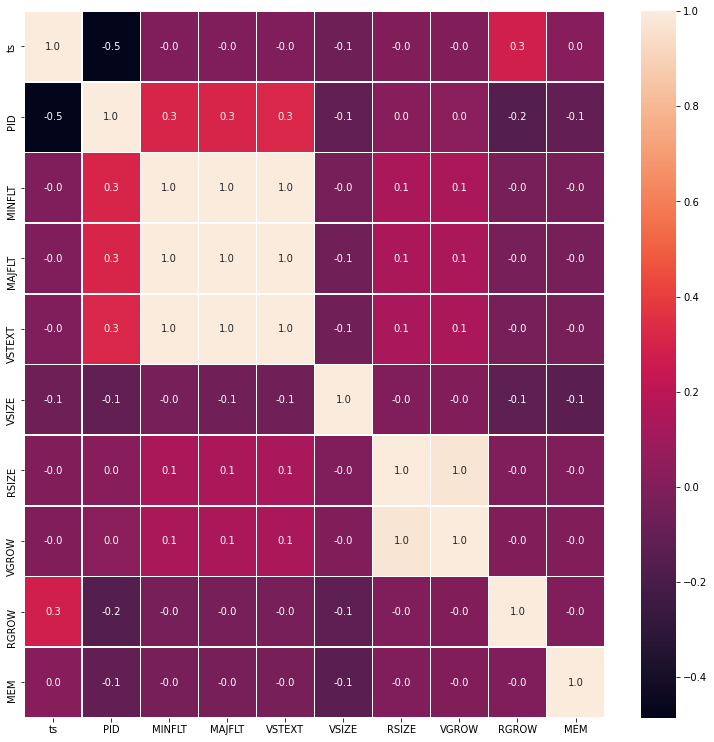

In [17]:
# Prepare data for plotting
plot_data = memory_train_20.select(
    [c for c in memory_train_20.columns if c not in ['attack', 'type', 'CMD']]
).toPandas()

# Draw the heatmap
f, ax = plt.subplots(figsize=(13, 13))
sns.heatmap(plot_data.corr(), annot=True, linewidths=.5, fmt= '.1f', ax=ax)

* The scatter plot below illustrates the relationship between the PID column and the attack label in the Memory Dataframe with a linear regression line fitting the given data. From the graph, it can be seen that all of the datapoints are distributed far away from the line, meaning that in this case, the linear regression line has a very high error. Consequently, the relationship between PID and attack is very vague.

<AxesSubplot:xlabel='PID', ylabel='attack'>

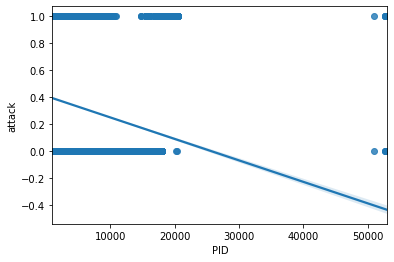

In [18]:
# Prepare data for plotting
plot_data = memory_train_20.select(
    [c for c in memory_train_20.columns if c in ['PID', 'attack']]
).toPandas()

# Draw the scatter plot
sns.regplot(x='PID', y='attack', data=plot_data, fit_reg=True)

##### Plots for Process dataframe

* The heatmap below illustrates the correlation between the numerical variables in the Process Dataframe. With each square showing the correlation points between two variables, the higher the value contained in the square gets, the more likely that the two corresponding variables are correlated. Therefore, it can be seen that there are no correlationships between the numerical features. Furthermore, the map also points out that the RTPR feature contains bad values that make no analytical impact. 

<AxesSubplot:>

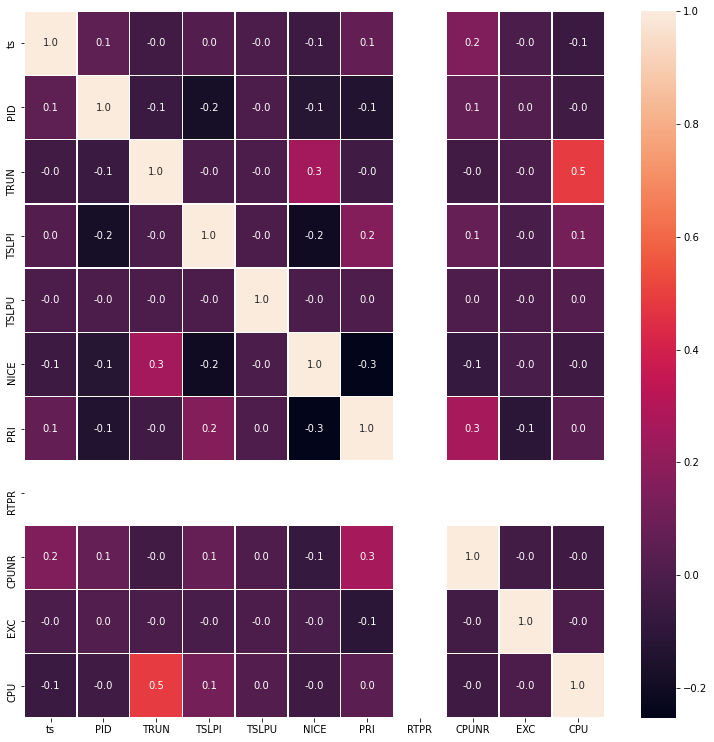

In [19]:
# Prepare data for plotting
plot_data = process_train_20.select(
    [c for c in process_train_20.columns if c not in ['attack', 'type', 'CMD', 'State', 'Status', 'POLI']]
).toPandas()

# Draw the heatmap
f, ax = plt.subplots(figsize=(13, 13))
sns.heatmap(plot_data.corr(), annot=True, linewidths=.5, fmt= '.1f', ax=ax)

* The scatter plot below illustrates the relationship between the PID column and the attack label in the Process Dataframe with a linear regression line fitting the given data. From the graph, it can be seen that the majority of the datapoints are distributed far away from the line, meaning that in this case, the linear regression line has a very high error. Consequently, the relationship between PID and attack is very loose.

<AxesSubplot:xlabel='PID', ylabel='attack'>

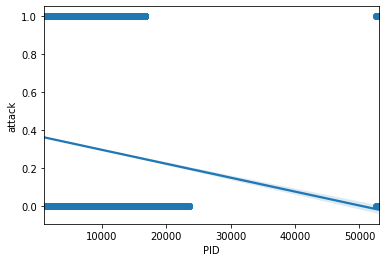

In [20]:
# Prepare data for plotting
plot_data = process_train_20.select(
    [c for c in process_train_20.columns if c in ['PID', 'attack']]
).toPandas()

# Draw the scatter plot
sns.regplot(x = 'PID', y='attack', data=plot_data, fit_reg=True)

<a class="anchor" name="two"></a>
## 2. Feature extraction and ML training

<a class="anchor" name="two_one"></a>
### 2.1. Preparing features, labels and models

* Based on the graphs above, the features for the machine learning models are selected. In the case of Memory Dataframe, since MINFLT, MAJFLT, and VSTEXT are correlated with each other, only one of them (MINFLT) is selected for training and testing the models. Similarly, between RSIZE and VGROW, only the former one is selected. In the case of Process Dataframe, since RTPR contains bad values and cannot bring about any analytical impacts, it is excluded from the machine learning models. With PID containing the IDs of the processes and CMD containing their names, both of them play same the role of identifying the process; nonetheless, as illustrated in the two scatter plots above, the relationship between PID and attack is very loose; therefore, in both cases of Memory and Process, PID and CMD are not included in the list of features. 


* In the case of Memory Dataframe, the list of features contains: `ts`, `MINFLT`, `VSIZE`, `RGROW`, `MEM`. All of them are numerical features; therefore, they can be immediately be assembled to one `feature` column. On the other hand, for the Process Dataframe, the list of features contains both numerical and categorical data; therefore, String Indexing and One-hot Encoding are applied before assembling the features into one column. The three cloumns `POLI`, `Status`, `State` in the Process Dataframe are the ones that have to go through String Indexing and One-hot Encoding before being merged into the `feature` column together with `ts`, `TRUN`, `TSLPI`, `TSLPU`, `NICE`, `PRI`, `CPUNR`, `EXC`, and `CPU`.


* After the features have been assembled into one single column, its value is then scaled using the Standard Scaler. The value of each row (`x`) is updated using the following formula: $x = \frac{x - \mu}{\sigma}$. By doing this, different features would be standardized to a common scale without having their range of value being distorted.

#### 2.1.1. Memory pipelines

* Prepare the training and testing data using the Rebalanced Memory Dataframe

In [21]:
# Generate the train data (20%) with the list of features
memory_train_data = memory_train_20[['ts', 'MINFLT', 'VSIZE', 'RSIZE', 'RGROW', 'MEM', 'attack']]\
        .withColumnRenamed('attack', 'label').cache()

# Generate the train data (100%) with the list of features
memory_train_full_data = memory_train_100[['ts', 'MINFLT', 'VSIZE', 'RSIZE', 'RGROW', 'MEM', 'attack']]\
        .withColumnRenamed('attack', 'label').cache()

# Generate the test data
memory_test_data = memory_test.withColumnRenamed('attack', 'label').cache()

##### Decision Tree Pipeline (Memory Pipeline 1)

In [22]:
# Assemble the features into one feature column
assembler_input = ['ts', 'MINFLT', 'VSIZE', 'RSIZE', 'RGROW', 'MEM']
stage_1 = VectorAssembler(inputCols=assembler_input, outputCol="features")

# Scale the feature column
stage_2 = StandardScaler(inputCol='features', outputCol='features_scaled', withStd=True, withMean=True)

# Specify the Machine Learning algorithm
stage_3 = DecisionTreeClassifier(featuresCol='features_scaled', labelCol='label')

# Create the pipeline
stages = [stage_1, stage_2, stage_3]
memory_pipeline_1 = Pipeline(stages=stages)

##### Gradient Boosted Tree Pipeline (Memory Pipeline 2)

In [23]:
# Assemble the features into one feature column
assembler_input = ['ts', 'MINFLT', 'VSIZE', 'RSIZE', 'RGROW', 'MEM']
stage_1 = VectorAssembler(inputCols=assembler_input, outputCol="features")

# Scale the feature column
stage_2 = StandardScaler(inputCol='features', outputCol='features_scaled', withStd=True, withMean=True)

# Specify the Machine Learning algorithm
stage_3 = GBTClassifier(featuresCol='features_scaled', labelCol='label')

# Create the pipeline
stages = [stage_1, stage_2, stage_3]
memory_pipeline_2 = Pipeline(stages=stages)

#### 2.1.2. Process pipelines

* Prepare the training and testing data using the Rebalanced Process Dataframe

In [24]:
# Generate the train data (20%) with the list of features
process_train_data = process_train_20[['ts', 'TRUN', 'TSLPI', 'TSLPU', 'POLI', 'NICE', 'PRI', 
                                       'CPUNR', 'Status', 'EXC', 'State', 'CPU', 'attack']]\
        .withColumnRenamed('attack', 'label').cache()

# Generate the train data (100%) with the list of features
process_train_full_data = process_train_100[['ts', 'TRUN', 'TSLPI', 'TSLPU', 'POLI', 'NICE', 'PRI', 
                                       'CPUNR', 'Status', 'EXC', 'State', 'CPU', 'attack']]\
        .withColumnRenamed('attack', 'label').cache()

# Generate the test data
process_test_data = process_test.withColumnRenamed('attack', 'label').cache()

##### Decision Tree Pipeline (Process Pipeline 1)

In [25]:
# String indexing the categorical features
index_input = ['POLI', 'Status', 'State']
index_output = ['POLI_idx', 'Status_idx', 'State_idx']
stage_1 = StringIndexer(inputCols=index_input, outputCols=index_output).setHandleInvalid("keep")

# One-hot encoding the categorical features
OHE_input = index_output
OHE_output = ['POLI_ohe', 'Status_ohe', 'State_ohe']
stage_2 = OneHotEncoder(inputCols=OHE_input, outputCols=OHE_output)

# Assemble the features (both numerical and categorical) into one feature column
assembler_input = ['ts', 'TRUN', 'TSLPI', 'TSLPU', 'NICE', 'PRI', 'CPUNR', 'EXC', 'CPU'] + OHE_output
stage_3 = VectorAssembler(inputCols=assembler_input, outputCol="features")

# Scale the feature column
stage_4 = StandardScaler(inputCol='features', outputCol='features_scaled', withStd=True, withMean=True)

# Specify the Machine Learning algorithm
stage_5 = DecisionTreeClassifier(featuresCol='features_scaled', labelCol='label')

# Create the pipeline
stages = [stage_1, stage_2, stage_3, stage_4, stage_5]
process_pipeline_1 = Pipeline(stages=stages)

##### Gradient Boosted Tree Pipeline (Process Pipeline 2)

In [26]:
# String indexing the categorical features
index_input = ['POLI', 'Status', 'State']
index_output = ['POLI_idx', 'Status_idx', 'State_idx']
stage_1 = StringIndexer(inputCols=index_input, outputCols=index_output).setHandleInvalid("keep")

# One-hot encoding the categorical features
OHE_input = index_output
OHE_output = ['POLI_ohe', 'Status_ohe', 'State_ohe']
stage_2 = OneHotEncoder(inputCols=OHE_input, outputCols=OHE_output)

# Assemble the features (both numerical and categorical) into one feature column
assembler_input = ['ts', 'TRUN', 'TSLPI', 'TSLPU', 'NICE', 'PRI', 'CPUNR', 'EXC', 'CPU'] + OHE_output
stage_3 = VectorAssembler(inputCols=assembler_input, outputCol="features")

# Scale the feature column
stage_4 = StandardScaler(inputCol='features', outputCol='features_scaled', withStd=True, withMean=True)

# Specify the Machine Learning algorithm
stage_5 = GBTClassifier(featuresCol='features_scaled', labelCol='label')

# Create the pipeline
stages = [stage_1, stage_2, stage_3, stage_4, stage_5]
process_pipeline_2 = Pipeline(stages=stages)

<a class="anchor" name="two_two"></a>
### 2.2. Training and evaluating models

* In this scenario, since the purpose of the study is to detect and stop attacks, the ultimate goal would be to find as many potential attacks as possible so as to come up with prevention. If an actual attack is not detected and prevented, horrendous consequences might arise and lead to a tremendous lost of time and money. Therefore, it is crucial that the probability of actual attacks not being detected by the system is minimized. For that reason, the Recall metric is the one that plays a crucial role when it comes to the evaluating the models' performance. However, in this case when the ratio of attack and non-attack events is 1:2, meaning that there are more non-attack events than the other type, this imbalance might lead to the low record of Recall and AUC of the models. As a result, F1 would be the most proper metric for the evaluation of the models.

In [27]:
# Function to calculate Accuracy, Precision, Recal, and F1
def compute_metrics(predictions):

    # Calculate the elements of the confusion matrix
    TN = predictions.filter('prediction = 0 AND label = 0').count()
    TP = predictions.filter('prediction = 1 AND label = 1').count()
    FN = predictions.filter('prediction = 0 AND label = 1').count()
    FP = predictions.filter('prediction = 1 AND label = 0').count()
    
    # Show confusion matrix
    predictions.groupBy('label', 'prediction').count().show()
    
    # Calculate metrics by the confusion matrix
    accuracy = (TP+TN)/(TP+TN+FN+FP)
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    f1 = 2/((1/recall)+(1/precision))
    
    # Put the result in form of a dictionary
    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }
    
    # Return result
    return metrics    

In [28]:
# Create evaluator for Binary Classification
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")

In [29]:
# User defined function to convert value to list
to_array = F.udf(lambda v: v.toArray().tolist(), ArrayType(FloatType()))

# Function to draw the ROC curve
def draw_roc(prediction):
    
    # Create a list of thresholds
    thresholds = np.linspace(0, 1, 100)
    
    # Split the probability column in halves
    df = prediction.withColumn('probability', to_array('probability'))
    # Create a temporary dataframe to store the two probability columns and label
    prob_df = df.select(df.probability[0].alias('negative_prob'), 
                        df.probability[1].alias('positive_prob'), 
                        'label').cache()
    
    # Lists containing multiple cases of TPR and FPR
    all_TPR = list()
    all_FPR = list()
    
    # For each threshold
    for th in thresholds:
        # Create a temporary dataframe with new column prediction based on the probability positive column
        test_df = prob_df.withColumn('prediction', F.when(prob_df.positive_prob > th, 1).otherwise(0)).cache()
        
        # Calculate the elements of the confusion matrix
        TN = test_df.filter('prediction = 0 AND label = 0').count()
        TP = test_df.filter('prediction = 1 AND label = 1').count()
        FN = test_df.filter('prediction = 0 AND label = 1').count()
        FP = test_df.filter('prediction = 1 AND label = 0').count()
        
        # Calculate the TPR and FPR then add them to the lists of results
        TPR = TP/(TP+FN)
        FPR = FP/(FP+TN)
        all_TPR.append(TPR)
        all_FPR.append(FPR)
        
    # Convert the list of TPR and FPR into a Pandas dataframe
    data = { 'TPR': all_TPR, 'FPR': all_FPR }
    data = pd.DataFrame(data)
 
    # Plot the curve using the dataframe
    plt.plot(data['FPR'],data['TPR'])
    plt.ylabel('TPR')
    plt.xlabel('FPR')
    plt.title('ROC Curve')
    plt.show()

#### 2.2.1. Memory models

##### Decision Tree Model (Memory Model 1)

In [30]:
# Train the model on train data (20%)
memory_model_1 = memory_pipeline_1.fit(memory_train_data)
# Test model on test data
memory_predictions_1 = memory_model_1.transform(memory_test_data)

In [31]:
# Compute the metrics
memory_metrics_1 = compute_metrics(memory_predictions_1)
memory_metrics_1['auc'] = evaluator.evaluate(memory_predictions_1)

+-----+----------+------+
|label|prediction| count|
+-----+----------+------+
|  1.0|       1.0| 39814|
|  0.0|       1.0| 25069|
|  1.0|       0.0|  1264|
|  0.0|       0.0|333452|
+-----+----------+------+



In [32]:
# Print out the metrics
pprint(memory_metrics_1)

{'accuracy': 0.934101436690282,
 'auc': 0.9534260012062076,
 'f1': 0.7514840365794964,
 'precision': 0.613627606614984,
 'recall': 0.9692292711427041}


In [34]:
# Extract list of features from the predictions
features = list()
for k,v in memory_predictions_1.schema['features'].metadata['ml_attr']['attrs'].items():
    features = features + v
features = sorted(features, key=lambda k: k['idx']) 

# Extract list of features from the machine learning stage
feature_importance = list(memory_model_1.stages[-1].featureImportances)

# Map the importance with the features
for i in range(len(features)):
    features[i]['importance'] = feature_importance[i]

# Print out the top 5 most important features
pprint(sorted(features, key=lambda k: k['importance'], reverse=True)[:5])

[{'idx': 0, 'importance': 0.9862011401542189, 'name': 'ts'},
 {'idx': 1, 'importance': 0.011947001273730615, 'name': 'MINFLT'},
 {'idx': 5, 'importance': 0.0013797653665704754, 'name': 'MEM'},
 {'idx': 4, 'importance': 0.0004323924173122691, 'name': 'RGROW'},
 {'idx': 3, 'importance': 3.970078816769665e-05, 'name': 'RSIZE'}]


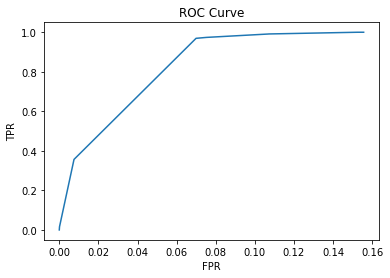

In [35]:
# Draw the ROC curve
draw_roc(memory_predictions_1)

##### Gradient Boosted Tree Model (Memory Model 2)

In [36]:
# Train the model on train data (20%)
memory_model_2 = memory_pipeline_2.fit(memory_train_data)
# Test model on test data
memory_predictions_2 = memory_model_2.transform(memory_test_data)

In [37]:
# Compute the metrics
memory_metrics_2 = compute_metrics(memory_predictions_2)
memory_metrics_2['auc'] = evaluator.evaluate(memory_predictions_2)

+-----+----------+------+
|label|prediction| count|
+-----+----------+------+
|  1.0|       1.0| 38314|
|  0.0|       1.0| 21086|
|  1.0|       0.0|  2764|
|  0.0|       0.0|337435|
+-----+----------+------+



In [38]:
# Print out the metrics
pprint(memory_metrics_2)

{'accuracy': 0.9403151659538688,
 'auc': 0.9831129760342711,
 'f1': 0.762634606580545,
 'precision': 0.645016835016835,
 'recall': 0.9327133745557232}


In [39]:
# Extract list of features from the predictions
features = list()
for k,v in memory_predictions_2.schema['features'].metadata['ml_attr']['attrs'].items():
    features = features + v
features = sorted(features, key=lambda k: k['idx']) 

# Extract feature importances from the machine learning stage
feature_importance = list(memory_model_2.stages[-1].featureImportances)

# Map the importance with the features
for i in range(len(features)):
    features[i]['importance'] = feature_importance[i]

# Print out the top 5 most important features
pprint(sorted(features, key=lambda k: k['importance'], reverse=True)[:5])

[{'idx': 0, 'importance': 0.8325031749940031, 'name': 'ts'},
 {'idx': 1, 'importance': 0.10856847673972875, 'name': 'MINFLT'},
 {'idx': 3, 'importance': 0.030827478947632627, 'name': 'RSIZE'},
 {'idx': 2, 'importance': 0.02461242390216867, 'name': 'VSIZE'},
 {'idx': 5, 'importance': 0.003206935357376593, 'name': 'MEM'}]


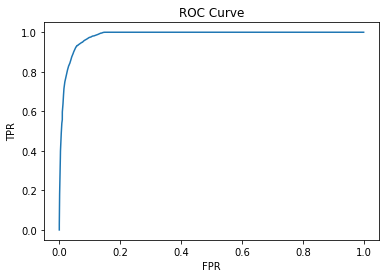

In [40]:
# Draw the ROC curve
draw_roc(memory_predictions_2)

#### 2.2.2. Process models

##### Decision Tree Model (Process Model 1)

In [41]:
# Train the model on train data (20%)
process_model_1 = process_pipeline_1.fit(process_train_data)
# Test the model on test data
process_predictions_1 = process_model_1.transform(process_test_data)

In [42]:
# Compute the metrics
process_metrics_1 = compute_metrics(process_predictions_1)
process_metrics_1['auc'] = evaluator.evaluate(process_predictions_1)

+-----+----------+------+
|label|prediction| count|
+-----+----------+------+
|  1.0|       1.0| 57675|
|  0.0|       1.0| 36876|
|  1.0|       0.0|   657|
|  0.0|       0.0|289913|
+-----+----------+------+



In [43]:
# Print out the metrics
pprint(process_metrics_1)

{'accuracy': 0.9025423178689295,
 'auc': 0.9358172422069296,
 'f1': 0.7544985380977609,
 'precision': 0.6099882603039629,
 'recall': 0.9887368854145238}


In [57]:
# Extract list of features from the predictions
features = list()
for k,v in process_predictions_1.schema['features'].metadata['ml_attr']['attrs'].items():
    features = features + v
features = sorted(features, key=lambda k: k['idx']) 

# Extract feature importances from the machine learning stage
feature_importance = list(process_model_1.stages[-1].featureImportances)

# Map the importance with the features
for i in range(len(features)):
    features[i]['importance'] = feature_importance[i]

# Create a list of grouped features
grouped_features = list()
# For each feature
for f in process_model_1.stages[-3].getInputCols():
    # Sum the importance from the feature attributes
    temp = 0
    for i in features:
        if f in i['name']:
            temp = temp + i['importance']
    
    # Add feature to the new list
    grouped_features.append({'name': f, 'importance':temp})
    
# Print out the top 5 most important features
pprint(sorted(grouped_features, key=lambda k: k['importance'], reverse=True)[:5])

[{'importance': 0.99790603054574, 'name': 'ts'},
 {'importance': 0.002093969454260047, 'name': 'Status_ohe'},
 {'importance': 0.0, 'name': 'TRUN'},
 {'importance': 0.0, 'name': 'TSLPI'},
 {'importance': 0.0, 'name': 'TSLPU'}]


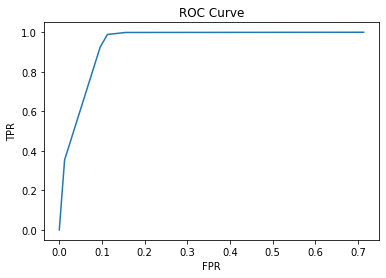

In [58]:
# Draw the ROC curve
draw_roc(process_predictions_1)

##### Gradient Boosted Tree Model (Process Model 2)

In [59]:
# Train the model on train data (20%)
process_model_2 = process_pipeline_2.fit(process_train_data)
# Test the model on test data
process_predictions_2 = process_model_2.transform(process_test_data)

In [60]:
# Compute the metrics
process_metrics_2 = compute_metrics(process_predictions_2)
process_metrics_2['auc'] = evaluator.evaluate(process_predictions_2)

+-----+----------+------+
|label|prediction| count|
+-----+----------+------+
|  1.0|       1.0| 55464|
|  0.0|       1.0| 28180|
|  1.0|       0.0|  2868|
|  0.0|       0.0|298609|
+-----+----------+------+



In [61]:
# Print out the metrics
pprint(process_metrics_2)

{'accuracy': 0.9193811814988017,
 'auc': 0.9793050358742355,
 'f1': 0.7813151518566517,
 'precision': 0.6630959781932954,
 'recall': 0.9508331619008434}


In [68]:
# Extract list of features from the predictions
features = list()
for k,v in process_predictions_2.schema['features'].metadata['ml_attr']['attrs'].items():
    features = features + v
features = sorted(features, key=lambda k: k['idx']) 

# Extract feature importances from the machine learning stage
feature_importance = list(process_model_2.stages[-1].featureImportances)

# Map the importance with the features
for i in range(len(features)):
    features[i]['importance'] = feature_importance[i]

# Create a list of grouped features
grouped_features = list()
# For each feature
for f in process_model_1.stages[-3].getInputCols():
    # Sum the importance from the feature attributes
    temp = 0
    for i in features:
        if f in i['name']:
            temp = temp + i['importance']
    
    # Add feature to the new list
    grouped_features.append({'name': f, 'importance':temp})
    
# Print out the top 5 most important features
pprint(sorted(grouped_features, key=lambda k: k['importance'], reverse=True)[:5])

[{'importance': 0.9228254412425805, 'name': 'ts'},
 {'importance': 0.031163531167051395, 'name': 'Status_ohe'},
 {'importance': 0.02514515826631648, 'name': 'CPU'},
 {'importance': 0.008884813813697615, 'name': 'CPUNR'},
 {'importance': 0.00850312261751445, 'name': 'TSLPI'}]


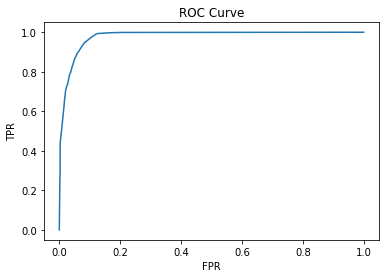

In [69]:
# Draw the ROC curve
draw_roc(process_predictions_2)

<a class="anchor" name="two_three"></a>
### 2.3. Persist the best models

* Based on the evaluation of the models, it can be seen that in the case of Memory Dataframe, the Gradient Boosted Tree Pipeline (Memory Pipeline 2) is the better one; similarly, for the Process Dataframe, the Gradient Boosted Tree Pipeline (Process Pipeline 2) is one that outperformed its counterpart. In the case of the Memory Dataframe, the Decision Tree Model (Memory Model 1) has a higher Recall than the Gradient Boosted Tree Model (Memory Model 2) (0.969 compared to 0.932). However, the F1 score of Memory Model 2 is slightly higher than that of Memory Model 1 (0.762 compared to 0.751), indicating that for the Memory Dataframe, the Gradient Boosted Tree algorithm provides a better result. Similarly, in the case of the Process Dataframe, the Decision Treen Model (Process Model 1) also has a higher Recall than the Gradient Boosted Tree Model (Process Model 2); nonetheless, Process Model 2 has a higher F1 score (0.781) compared to that of the Process Model 1 (0.754). For that reason, Process Pipeline 2 should be chosen as the one to be re-trained using 100% of the data. The selection of Gradient Boosted Tree Model for both cases is can be explained through the fact that compared to `DecisionTreeClassifer`, which only generates one tree, `GBTClassifier` generates multiple trees with the later ones help improves their former counterparts' classification result [1]. Consequently, this algorithm is capable of providing outcomes with lower error.


* Examining the top 5 most important features of each model, it can be seen that in all four cases, the `ts` feature always stay at the top with a dominating score. This feature's importance score was always higher than 0.8 and even reached more than 0.9 in three of the four examined cases. Based on the explanation provided by Apache Spark [2], the importance score is calculated based on the information gain when using the feature as a node to split the data. We can see that the domination of `ts`'s information gain score indicates that this feature is the one that has the strongest influence on the formation of the decision trees and that the splitting of the trees' nodes replies heavily on this feature. There is no doubt that `ts` has to be included in all of the models. 

#### 2.3.2. Gradient Boosted Tree on Memory Dataframe (100%)

In [71]:
# Train the model on train data (100%)
memory_model_3 = memory_pipeline_2.fit(memory_train_full_data)
# Test the model on test data 
memory_predictions_3 = memory_model_3.transform(memory_test_data)

In [72]:
# Compute the metrics
memory_metrics_3 = compute_metrics(memory_predictions_3)
memory_metrics_3['auc'] = evaluator.evaluate(memory_predictions_3)

+-----+----------+------+
|label|prediction| count|
+-----+----------+------+
|  1.0|       1.0| 38575|
|  0.0|       1.0| 24344|
|  1.0|       0.0|  2503|
|  0.0|       0.0|334177|
+-----+----------+------+



In [73]:
# Print out the metrics
pprint(memory_metrics_3)

{'accuracy': 0.932815147185053,
 'auc': 0.9833563341013156,
 'f1': 0.7418483225477658,
 'precision': 0.6130898456745975,
 'recall': 0.9390671405618579}


In [76]:
# Extract list of features from the predictions
features = list()
for k,v in memory_predictions_3.schema['features'].metadata['ml_attr']['attrs'].items():
    features = features + v
features = sorted(features, key=lambda k: k['idx']) 

# Extract feature importances from the machine learning stage
feature_importance = list(memory_model_3.stages[-1].featureImportances)

# Map the importance with the features
for i in range(len(features)):
    features[i]['importance'] = feature_importance[i]

# Print out the top 5 most important features
pprint(sorted(features, key=lambda k: k['importance'], reverse=True)[:5])

[{'idx': 0, 'importance': 0.8160101284288671, 'name': 'ts'},
 {'idx': 1, 'importance': 0.07041539179658522, 'name': 'MINFLT'},
 {'idx': 2, 'importance': 0.06541898436515795, 'name': 'VSIZE'},
 {'idx': 3, 'importance': 0.04683326035926473, 'name': 'RSIZE'},
 {'idx': 5, 'importance': 0.0010060077018362403, 'name': 'MEM'}]


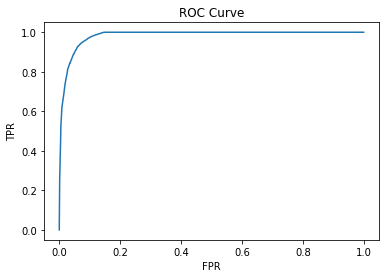

In [77]:
# Draw the ROC curve
draw_roc(memory_predictions_3)

#### 2.3.2. Gradient Boosted Tree on Process Dataframe (100%)

In [78]:
# Train the model on train data (100%)
process_model_3 = process_pipeline_2.fit(process_train_full_data)
# Test the model on test data 
process_predictions_3 = process_model_3.transform(process_test_data)

In [79]:
# Compute the metrics
process_metrics_3 = compute_metrics(process_predictions_3)
process_metrics_3['auc'] = evaluator.evaluate(process_predictions_3)

+-----+----------+------+
|label|prediction| count|
+-----+----------+------+
|  1.0|       1.0| 55700|
|  0.0|       1.0| 28375|
|  1.0|       0.0|  2632|
|  0.0|       0.0|298414|
+-----+----------+------+



In [80]:
# Print out the metrics
pprint(process_metrics_3)

{'accuracy': 0.919487641546423,
 'auc': 0.9801085317742896,
 'f1': 0.7822649167526877,
 'precision': 0.6625037169194172,
 'recall': 0.9548789686621408}


In [81]:
# Extract list of features from the predictions
features = list()
for k,v in process_predictions_3.schema['features'].metadata['ml_attr']['attrs'].items():
    features = features + v
features = sorted(features, key=lambda k: k['idx']) 

# Extract feature importances from the machine learning stage
feature_importance = list(process_model_3.stages[-1].featureImportances)

# Map the importance with the features
for i in range(len(features)):
    features[i]['importance'] = feature_importance[i]

# Create a list of grouped features
grouped_features = list()
# For each feature
for f in process_model_1.stages[-3].getInputCols():
    # Sum the importance from the feature attributes
    temp = 0
    for i in features:
        if f in i['name']:
            temp = temp + i['importance']
    
    # Add feature to the new list
    grouped_features.append({'name': f, 'importance':temp})
    
# Print out the top 5 most important features
pprint(sorted(grouped_features, key=lambda k: k['importance'], reverse=True)[:5])

[{'importance': 0.9162054541100456, 'name': 'ts'},
 {'importance': 0.031090591379289018, 'name': 'Status_ohe'},
 {'importance': 0.030221398144447943, 'name': 'CPU'},
 {'importance': 0.012002057894844478, 'name': 'CPUNR'},
 {'importance': 0.008025784464799315, 'name': 'TSLPI'}]


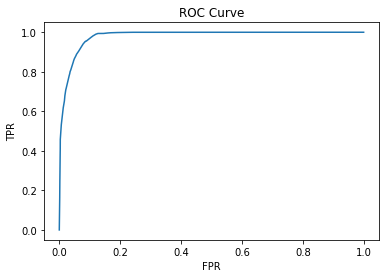

In [82]:
# Draw the ROC curve
draw_roc(process_predictions_3)

<a class="anchor" name="three"></a>
## 3. Knowledge sharing

* Sample code used to examine the operation of a KMeans Clustering Model:

In [3]:
# Create the dataframe
iris_df = spark.createDataFrame(
    [
        (4.7, 3.2, 1.3, 0.2),
        (4.9, 3.1, 1.5, 0.1),
        (5.4, 3.9, 1.3, 0.4),
        (5.0, 3.4, 1.6, 0.2),
        (5.1, 3.8, 1.6, 0.2),
        (4.9, 2.4, 3.3, 1.0),
        (6.6, 2.9, 4.6, 1.3),
        (5.6, 3.0, 4.5, 1.5),
        (5.7, 2.6, 3.5, 1.0),
        (5.8, 2.6, 4.0, 1.2),
        (5.8, 2.8, 5.1, 2.4),
        (6.2, 2.8, 4.8, 1.8),
        (6.0, 3.0, 4.8, 1.8),
        (6.7, 3.1, 5.6, 2.4),
        (6.7, 3.0, 5.2, 2.3),
        (6.2, 3.4, 5.4, 2.3)
    ],
    ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
)

In [4]:
# Assemble all columns into one feature
assembler = VectorAssembler(inputCols=['sepal_length', 'sepal_width', 'petal_length', 'petal_width'],
                            outputCol='features')

# Transform the data and use it to train the machine learning algorithm
kmeans = KMeans(k=3).fit(assembler.transform(iris_df))

* The image below shows that in total, 10 jobs were executed when training the model. With the `iris_df` being distributed into two partitions, there are two jobs executed for each step of the KMeans clustering algorithm, except for the `countByValue at KMeans` and `collect at ClusteringSummary` jobs, which summarized records from the two partitions. The first two jobs, namely Job 0 and 1: `takeSample at KMeans`, were executed to randomly initialize the centroids for the clusters. After the centroids have been initialized, distances from the datapoints to the centroids were calculated. The aforementioned step were demonstrated by the combination of the two jobs: `sum at KMeans` and `collect at KMeans` (Jobs 2 and 3, and Jobs 4 and 5). Then, each datapoint was assigned to the nearest cluster based on the distance from the datapoint and the cluster's centroid through Job 6: `countByValue at KMeans`. Coordinates of each cluster's centroid was then re-calculated using the datapoints that it contains. After the centroids had been updated, datapoints were then re-assigned to their nearest clusters. The re-calculation of centroids and re-assignment of datapoints were carried out through the `collectAsMap at KMeans` job (Job 7 and 8). The final job (Job 9) `collect at ClusteringSummary` played the role of combining the results of the parallel processes.

<img src='jobs.png'/>

In [6]:
# Stop the Spark application
sc.stop()

# Rerferences

[1] Harshdeep Singh, *Understanding Gradient Boosting Machines*, Towards Data Science, Nov.4, 2018. Accessed on Sep. 28, 2020. Available: https://towardsdatascience.com/understanding-gradient-boosting-machines-9be756fe76ab


[2] Apache Spark API, *PySpark 2.1.0 Documentation*. Accessed on Sep. 28, 2020 [Online]. Available: http://spark.apache.org/docs/2.1.0/api/python/pyspark.ml.html?highlight=featureimportance#pyspark.ml.classification.DecisionTreeClassificationModel.featureImportances